---
# **Sentiment Analysis**
---

---

# **1. Installation**

---

## i. Generating a reponse


In [1]:
import sys
import logging
from psutil import virtual_memory

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
ram_gb = virtual_memory().total / 1e9

In [3]:
tf_response = {
    'error': None,
    'TF version': '',
    'COLAB': None,
    'GPU': False,
    'ram_gb': ''
}

In [4]:
try:
    # drive
    from google.colab import drive
    IN_COLAB = 'google.colab' in sys.modules

    # updating tensorflow version
    %tensorflow_version 2.x

    # tensorflow-gpu & tensorflowjs
    !pip install tensorflow-gpu # !pip install tensorflow_text # I could use BERT
    !pip install tensorflowjs

    # NLP (nltk, stanza, spacy)
    !pip install nltk 
    !pip install stanza
    !pip install spacy
    !spacy download en_core_web_sm # sm md lg
    !python -m spacy download en
except OSError as error:
    # debugging error
    response['error'] = logging.debug('You are not using your specify version of TensorFlow')
    IN_COLAB = False

    # install requirements
    !pip install -r '../requirements.txt'
finally:
    tf_response['COLAB'] = IN_COLAB
    
    # Importing tensroflow core
    import tensorflow as tf
    import tensorflowjs as tfjs
    from tensorflow import keras
    from keras.callbacks import TensorBoard
    from keras.utils import to_categorical

    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences

    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional, GlobalMaxPool1D

    from sklearn.model_selection import train_test_split
    
    # GPU and RAM response
    if tf.config.list_physical_devices('GPU'):
        GPU = True
        tf_response['GPU'] = GPU
        tf_response['TF_version'] = tf.__version__
        
        if tf_response['COLAB'] == True:
            if gpu_info.find('failed') >= 0:
                print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator')
                print('Re-execute this cell.')
            else:
                print(gpu_info)
            
            if ram_gb < 20:
                print('To enable a high-RAM runtime, select the Runtime > "Change runtime type menu"')
                print('Select high-RAM in the runtime shape dropdown')
                print('Re-execute this cell')
                tf_response['ram_gb'] = 'low-RAM runtime'
            else:
                tf_response['ram_gb'] = 'high-RAM runtime'
            print('\nRuntime {:.2f} GB of available RAM\n'.format(ram_gb))

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
Sun Oct 25 09:53:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off

In [5]:
tf_response

{'COLAB': True,
 'GPU': True,
 'TF version': '',
 'TF_version': '2.3.1',
 'error': None,
 'ram_gb': 'high-RAM runtime'}

In [6]:
# tensorboard folder
!rm -rf logs
!mkdir logs

## ii. Importing modules


In [7]:
# Data analysis
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import re

%matplotlib inline

In [8]:
# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
# Stanza NLP
import stanza

stanza.download('en', package='ewt', processors='tokenize,mwt,pos,lemma', verbose=True)
stNLP = stanza.Pipeline(processors='tokenize,mwt,pos,lemma',
                      lang='en',
                      use_gpu=True)

2020-10-25 09:53:57 WARNING: Can not find mwt: ewt from official model list. Ignoring it.
2020-10-25 09:53:57 INFO: Downloading these customized packages for language: en (English)...
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |
| lemma     | ewt     |
| pretrain  | ewt     |

2020-10-25 09:53:57 INFO: File exists: /root/stanza_resources/en/tokenize/ewt.pt.
2020-10-25 09:53:57 INFO: File exists: /root/stanza_resources/en/pos/ewt.pt.
2020-10-25 09:53:57 INFO: File exists: /root/stanza_resources/en/lemma/ewt.pt.
2020-10-25 09:53:57 INFO: File exists: /root/stanza_resources/en/pretrain/ewt.pt.
2020-10-25 09:53:57 INFO: Finished downloading models and saved to /root/stanza_resources.
2020-10-25 09:53:57 WARNING: Can not find mwt: default from official model list. Ignoring it.
2020-10-25 09:53:57 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt  

In [10]:
# testing stanza
doc = stNLP('Barack Obama was born in Hawai.')
print(*[f'word: {word.text+" "}\tlemma: {word.lemma}' for sent in doc.sentences for word in sent.words], sep='\n')

word: Barack 	lemma: Barack
word: Obama 	lemma: Obama
word: was 	lemma: be
word: born 	lemma: bear
word: in 	lemma: in
word: Hawai 	lemma: Hawai
word: . 	lemma: .


In [11]:
# Spacy NLP
import spacy
spNLP = spacy.load('en_core_web_sm')
spNLP.max_length = 103950039 # or higher
# spacy.prefer_gpu() #will not work with stanza


---

# **2. Hyperparameters**

---

In [12]:
FILE = 'datasets/categories_dataset.csv'
MODEL_PATH = './models/model.h5'

In [13]:
EPOCHS = 200 
BATCH_SIZE = 8 # 8, 16, 32, 64, 128  ## 256 # Big enough to measure an F1-score
vocab_size = 5000
padding_shape = 30

In [14]:
main_labels = ['confident', 'unconfident',
               'pos_hp', 'neg_hp',
               'interested', 'uninterested',
               'happy', 'unhappy',
               'friendly', 'unfriendly']

label_dict = dict(zip(main_labels, range(1, len(main_labels) + 1)))

In [15]:
label_dict

{'confident': 1,
 'friendly': 9,
 'happy': 7,
 'interested': 5,
 'neg_hp': 4,
 'pos_hp': 3,
 'unconfident': 2,
 'unfriendly': 10,
 'unhappy': 8,
 'uninterested': 6}

---

# **3. Lemmatization**

---

In [16]:
# lemmatizion
# stanza
def stanza_lemma(text):
    doc = stNLP(text)
    return ' '.join([word.lemma for sent in doc.sentences for word in sent.words])

In [17]:
def nltk_lemma(text):
    lemmatizer = WordNetLemmatizer()
    lemmatizer.lemmatize(text)

---
# **4. Load dataset**
---

In [18]:
def load_clean_dataset():
    !mkdir -p datasets
    !wget -nc https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/results/categories_dataset_min_counter.csv -P datasets
    df = pd.read_csv('./datasets/categories_dataset_min_counter.csv', encoding='utf-8', index_col=0)
    
    print(df.head())
    x, y = df['word'], df['category']

    return x, y

---
# **5. Prepare dataset**
---

In [19]:
def preprocess(x, padding_shape=30):
    return np.array([ord(i.lower()) - ord('a')+1 if not i.isdigit() and i != ' ' else 0 for i in list(x)] + ([0] * (padding_shape - len(x))), dtype=int)

In [20]:
def prepare_dataset(labeldict : dict, test_size=.3, validation_size=.1): 
    print('preparing the dataset...\n')
    
    from sklearn import preprocessing

    # load dataset
    # split dataset (as string into panda.core.series.Serie object)
    x, y = load_clean_dataset()

    x = np.array(list(map(preprocess, x)))
    y = np.array(list(map(lambda x: labeldict[x.replace(' ', '_')], y)))
    print(('\n\ny array: \n{}').format(y))

    # create/split train, validation and test and shuffle the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, shuffle=True)
    print(x.max(), x.min())

    x_train_val, x_validation, y_train_val, y_validation = train_test_split(x_train, y_train, test_size=test_size, shuffle=True)

    # pandas.core.series.Series to numpy array
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_validation, y_validation =  np.array(x_validation), np.array(y_validation)
    x_test, y_test = np.array(x_test), np.array(y_test)
    
    x_train_val, y_train_val = np.array(x_train_val), np.array(y_train_val)

    # to categorical : y
    y_train = to_categorical(y_train-1)
    y_validation = to_categorical(y_validation-1)
    y_test = to_categorical(y_test-1)
    y_train_val = to_categorical(y_train_val-1)
    print(('\nx_train: \n{}\n\ny_train: \n{}').format(x_train_val, y_train_val))

    return (x_train, y_train), (x_validation, y_validation), (x_test, y_test), (x_train_val, y_train_val)

---
# **4. Build model**
---

In [21]:
def build_model(vocab_size, embedding_dim=64, input_length=30):
    print('\nbuilding the model...\n')

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=(vocab_size + 1), output_dim=embedding_dim, input_length=input_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1)),
        tf.keras.layers.GlobalMaxPool1D(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(64, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(l2=0.00001)),
        
        # softmax output layer
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    # optimizer & loss
    opt = tf.optimizers.RMSprop(learning_rate=0.01)
    loss = 'categorical_crossentropy'

    # Metrics
    # AUC: Computes the approximate AUC (Area Under the Curve) via a Riemann sum.
    # Precision: Computes the precision of the predictions with respect to the labels.
    # Recall: Computes the recall of the predictions with respect to the labels.
    metrics = ['accuracy', 'AUC','Precision', 'Recall']

    # compile model
    model.compile(optimizer=opt, 
                  loss=loss,
                  metrics=metrics)
    
    model.summary()

    return model

---
# **6. Train model** 
---

In [22]:
def train(model, x_train, y_train, x_validation, y_validation,
          epochs, batch_size=32, patience=5, 
          verbose=2, monitor_es='accuracy', mode_es='auto', restore=True,
          monitor_mc='val_accuracy', mode_mc='max'):
    
    print('\ntraining...\n')
    print(x_train.shape, y_train.shape)
    
    # callback
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor_es,
                                                      verbose=1, mode=mode_es, restore_best_weights=restore,
                                                      min_delta=1e-3, patience=patience)
    
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint('tfjsmode.h5', monitor=monitor_mc, mode=mode_mc,      
                                                          verbose=1, save_best_only=True)

    # Define Tensorboard as a Keras callback
    #tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, write_images=True)

    keras_callbacks = [early_stopping, model_checkpoint]

    # train model
    history = model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs, verbose=verbose,
                        validation_data=(x_validation, y_validation),
                        callbacks=keras_callbacks)
    return history

---
# **7. Plotting history**
---

In [23]:
def plot_history(history, string):
    fitModel_dict = history.history

    plt.figure(figsize=(10, 6))
    plt.plot(fitModel_dict[string])
    plt.plot(fitModel_dict['val_' + string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

---
# **8. Prediction**
---

In [24]:
def predict(d : dict, s : str, model):
    token = preprocess(s)
    output = model.predict(np.array([token]))
    id = int(tf.keras.backend.argmax(output))
    print(output)

    for k, v in d.items():
        if v == id:
            return k

    return 'unclassified'

---
# **9. Main**
---

## Preparing dataset & building the model

In [25]:
# prepare the dataset
(x_train, y_train), (x_validation, y_validation), (x_test, y_test), (x_test_val, y_test_val) = prepare_dataset(label_dict, test_size=.2)

print('\n\nX shapes\n')
print(x_train.shape, x_validation.shape, x_test.shape)

print('\n\nY shapes\n')
print(y_train.shape, y_validation.shape, y_test.shape)

print('\n\nY train')
print(y_train)

# build the model
model = build_model(vocab_size)

preparing the dataset...

File ‘datasets/categories_dataset_min_counter.csv’ already there; not retrieving.

   Arousal  Compound  Dominance  ... Valence   category          word
0     0.55      0.30       0.74  ...    0.89  confident     tolerance
1     0.55      0.00       0.74  ...    0.89  confident         carry
2     0.55      0.42       0.74  ...    0.89  confident   tranquility
3     0.55      0.00       0.74  ...    0.89  confident  socontagious
4     0.55      0.00       0.74  ...    0.89  confident          zeal

[5 rows x 12 columns]


y array: 
[1 1 1 ... 6 6 6]
26 0

x_train: 
[[ 2 18 15 ...  0  0  0]
 [ 2  5  1 ...  0  0  0]
 [16 15  9 ...  0  0  0]
 ...
 [ 8  1 14 ...  0  0  0]
 [13  5  1 ...  0  0  0]
 [19 16  1 ...  0  0  0]]

y_train: 
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


X shapes

(26128, 30) (5226, 30) (6532, 30)


Y shapes

(26128, 10) (5226, 10

## Training

In [26]:
# train the model
history = train(model=model, x_train=x_train, y_train=y_train, batch_size=BATCH_SIZE,
                x_validation=x_validation, y_validation=y_validation,
                epochs=EPOCHS, verbose=1, monitor_es='val_loss', mode_es='min', restore=False)


training...

(26128, 30) (26128, 10)
Epoch 1/200
3265/3266 [============================>.] - ETA: 0s - loss: 2.3147 - accuracy: 0.1081 - auc: 0.5139 - precision: 0.0714 - recall: 3.8285e-05
Epoch 00001: val_accuracy improved from -inf to 0.12074, saving model to tfjsmode.h5
3266/3266 [==============================] - 56s 17ms/step - loss: 2.3148 - accuracy: 0.1080 - auc: 0.5139 - precision: 0.0714 - recall: 3.8273e-05 - val_loss: 2.3081 - val_accuracy: 0.1207 - val_auc: 0.5371 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
3263/3266 [============================>.] - ETA: 0s - loss: 2.3037 - accuracy: 0.1211 - auc: 0.5363 - precision: 0.1111 - recall: 3.8308e-05
Epoch 00002: val_accuracy improved from 0.12074 to 0.13337, saving model to tfjsmode.h5
3266/3266 [==============================] - 54s 16ms/step - loss: 2.3036 - accuracy: 0.1211 - auc: 0.5363 - precision: 0.1111 - recall: 3.8273e-05 - val_loss: 2.2879 - val_accuracy: 0.1334 - val_auc: 0.5509 - val_precis

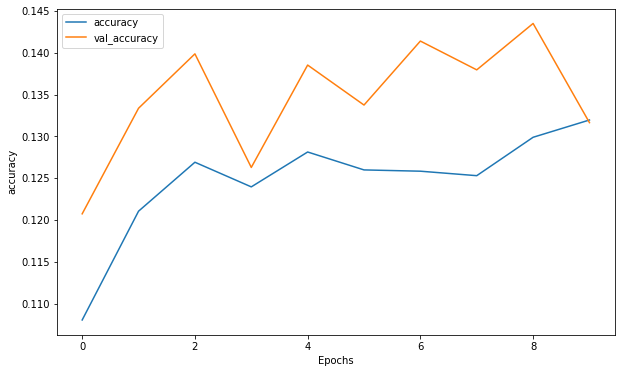

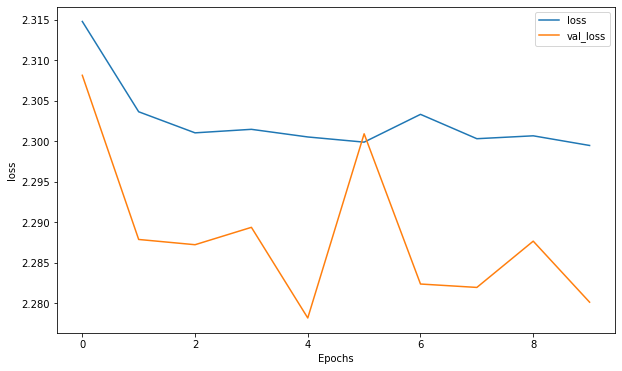

In [27]:
plot_history(history, 'accuracy')
plot_history(history, 'loss')

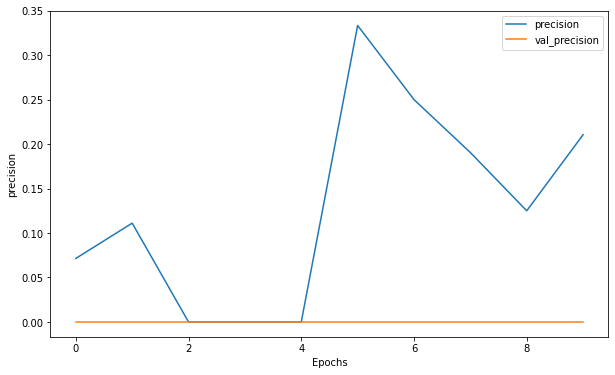

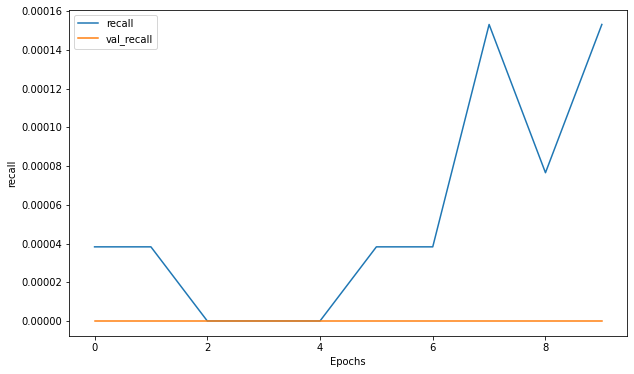

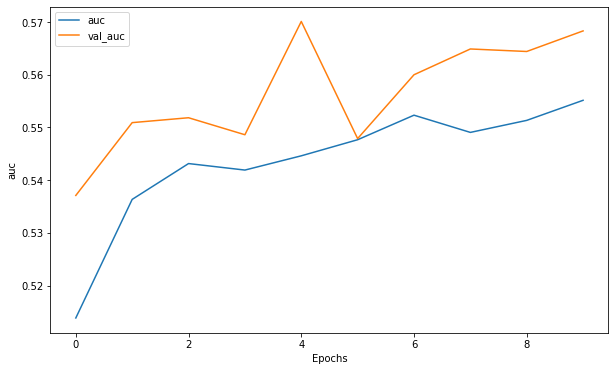

In [28]:
plot_history(history, 'precision')
plot_history(history, 'recall')
plot_history(history, 'auc')

In [29]:
# tensorboard
#%load_ext tensorboard
#%tensorboard --logdir logs

## Evaluate the model

In [30]:
def evaluate_model(x_test_val, y_test_val):
    # evaluate the model
    test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(x_test_val, y_test_val)

    # to list, zip and dict
    test_names = ['loss', 'accuracy', 'auc', 'precision', 'recall']
    evaluate_lst = list(map(lambda x: x * 100, [test_loss, test_accuracy, test_auc, test_precision, test_recall]))
    evaluate_dict = dict(zip(test_names, evaluate_lst))

    for test_names, test_value in evaluate_dict.items():
        print(('Test {}: {:.2f} %').format(test_names, test_value))

In [31]:
evaluate_model(x_test_val, y_test_val)

654/654 [==============================] - 5s 8ms/step - loss: 2.2796 - accuracy: 0.1397 - auc: 0.5680 - precision: 0.0000e+00 - recall: 0.0000e+00
Test loss: 227.96 %
Test accuracy: 13.97 %
Test auc: 56.80 %
Test precision: 0.00 %
Test recall: 0.00 %


## Predict

In [32]:
s = 'smiling'
pred = predict(label_dict, s, model)
print('Word: {}'.format(s))
print('Prediction: {}'.format(pred))

[[0.10564805 0.10386076 0.10358526 0.08061245 0.12630267 0.09264978
  0.10328559 0.09060875 0.0934013  0.10004541]]
Word: smiling
Prediction: neg_hp


In [33]:
def predict_softmax(d: dict, s : str, model):
    token = preprocess(s)
    output = model.predict(np.array([token]))

    for i in output:
        output_lst = list(i)
    print(output)
    return dict(zip(d, output_lst))    

In [34]:
s = 'smile'
pred_soft = predict_softmax(label_dict, s, model)

[[0.08191519 0.14383106 0.05782928 0.07360274 0.11041979 0.13073555
  0.11806896 0.09936574 0.08408567 0.10014602]]


In [35]:
for k, v in pred_soft.items():
    print('{}:{}'.format(k, v))

confident:0.08191519230604172
unconfident:0.1438310593366623
pos_hp:0.057829275727272034
neg_hp:0.07360273599624634
interested:0.11041979491710663
uninterested:0.13073554635047913
happy:0.11806895583868027
unhappy:0.09936574101448059
friendly:0.08408566564321518
unfriendly:0.10014601796865463


## Saving & converting the model

In [36]:
# save the model
!mkdir models
model.save(MODEL_PATH)

mkdir: cannot create directory ‘models’: File exists


In [37]:
# convert to modeljs
tfjs.converters.save_keras_model(model, 'tfjsmodel')

/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)
